In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point

In [3]:
file_path = 'D:/data/'

# Step 1

## 1. facility data

In [115]:
# Import facilities' locations and remove all spaces and question marks from the '병원명' column.
facility = gpd.read_file(file_path + 'facilities.shp')
facility['병원명'] = facility['병원명'].str.replace(' ', '', regex=True)
facility['병원명'] = facility['병원명'].str.replace('?', '', regex=True)
facility = facility[facility['주소'].str.startswith('서울')]

# Rename the column '격리실' to 'capacity.'
facility = facility.rename(columns={'격리실': 'capacity'})


# Import facilities' buffer polygons (Service Areas analyzed in ArcMap).
fac_buffer = gpd.read_file(file_path + 'fac_buffer.shp')

# Extract and keep only Korean characters in the 'Name' column in fac_buffer.
fac_buffer['name'] = fac_buffer['Name'].str.extract('([가-힣 ]+)')

# Remove all spaces in the 'Name' column.
fac_buffer['name'] = fac_buffer['name'].str.replace(' ', '')


# Perform a spatial join between 'fac_buffer' and 'facility' based on the 'name' column.
fac_buffer = fac_buffer[['name', 'geometry']].merge(facility[['병원명', 'capacity']], left_on='name', right_on='병원명', how='left')
fac_buffer = fac_buffer[['name', 'capacity', 'geometry']]

# Create a copy of 'fac_buffer' as 'fac_buffer2'.
fac_buffer2 = fac_buffer.copy()
fac_buffer3 = fac_buffer.copy()

## 2. population data

In [121]:
# Import population density center points
point_pop = gpd.read_file(file_path + 'point_pop.shp')
point_pop['den'] = point_pop['SUM_1인']
point_pop = point_pop[point_pop['ADM_CD'].str.startswith('1')]

# Import resident density aged over 65 center points
point_65 = gpd.read_file(file_path + 'point.shp')
point_65['den'] = point_65['65DEN']
point_65['ADM_CD'] = point_65['ADM_CD'].astype(str)

# Import COVID-19 confirmed cases density center points
point_covid = gpd.read_file(file_path + 'point_covid.shp')
point_covid['den'] = point_covid['dencity']
point_covid = point_covid[point_covid['ADM_CD'].str.startswith('1')]

# Import population buffer
pop_buffer = gpd.read_file(file_path + 'pop_buffer.shp')
pop_buffer = pop_buffer[pop_buffer['Name'].str.startswith('11')]

In [117]:
# Perform a spatial join between facility buffers and population density center points,
# as well as COVID-19 patient density center points.
fac_buf_dfs = [fac_buffer, fac_buffer2, fac_buffer3]
pop_dfs = [point_pop, point_65, point_covid]

for df, pop_df in zip(fac_buf_dfs, pop_dfs):
    result = gpd.sjoin(df, pop_df, how="inner", predicate="intersects")
    
    # Calculate the sum of population density ('den') for each facility buffer area.
    sum_pop_rate = result.groupby('name')['den'].sum().reset_index()
    sum_pop_rate.rename(columns={'den': 'den_sum'}, inplace=True)
    
    # Add a 'den_sum' column to the facility buffer data based on the calculated population density sums.
    df['den_sum'] = df['name'].map(sum_pop_rate.set_index('name')['den_sum'])

# Step 2

## 1. population data

In [123]:
# Import population buffer polygons (Service Areas analyzed in ArcMap).
pop_buffer = gpd.read_file(file_path + 'pop_buffer.shp')

# Extract and keep only the part before the colon in the 'Name' column and remove leading/trailing spaces.
pop_buffer['Name'] = pop_buffer['Name'].str.split(':').str[0].str.strip()

# Perform a spatial join between 'pop_buffer' and 'point_pop' based on the 'Name' and 'ADM_CD' columns.
pop_den_buffer = pop_buffer[['Name', 'geometry']].merge(point_pop[['ADM_CD', 'den']], left_on='Name', right_on='ADM_CD', how='left')
pop_den_buffer = pop_den_buffer[['Name', 'den', 'geometry']]
pop_den_buffer = pop_den_buffer.sort_values(by='Name', ascending=False)

# Perform a spatial join between 'pop_buffer' and 'point_covid' based on the 'Name' and 'ADM_CD' columns.
eld_den_buffer = pop_buffer[['Name', 'geometry']].merge(point_65[['ADM_CD', 'den']], left_on='Name', right_on='ADM_CD', how='left')
eld_den_buffer = eld_den_buffer[['Name', 'den', 'geometry']]

# Perform a spatial join between 'pop_buffer' and 'point_covid' based on the 'Name' and 'ADM_CD' columns.
covid_den_buffer = pop_buffer[['Name', 'geometry']].merge(point_covid[['ADM_CD', 'den']], left_on='Name', right_on='ADM_CD', how='left')
covid_den_buffer = covid_den_buffer[['Name', 'den', 'geometry']]

## 2. spatial join

In [124]:
# Perform a spatial join between population buffer and facility buffer dataframes
dfs = [pop_den_buffer, eld_den_buffer, covid_den_buffer]
fac_dfs = [fac_buffer, fac_buffer2, fac_buffer3]

for df, fac_df in zip(dfs, fac_dfs):
    result = gpd.sjoin(df, fac_df, how="inner", predicate="intersects")
    
    # Calculate the sum of 'den' values for each population buffer area.
    sum_ProToPop = result.groupby('Name')['den'].sum().reset_index()
    sum_ProToPop.rename(columns={'den': 'sfca'}, inplace=True)
    
    # Add an 'sfca' column to the population buffer dataframe based on the calculated 'den' sums.
    df['sfca'] = df['Name'].map(sum_ProToPop.set_index('Name')['sfca'])

## 3. join to unit

In [134]:
# Load municipal boundaries data.
boundary = gpd.read_file(file_path + 'boundary.shp')

# Perform a spatial join between municipal boundaries and population density data ('pop_den_buffer').
pop_sfca = boundary[['ADM_CD', 'geometry']].merge(pop_den_buffer[['Name', 'sfca']], left_on='ADM_CD', right_on='Name', how='left')
pop_sfca = pop_sfca[pop_sfca['Name'].notna() & pop_sfca['Name'].str.startswith('11')]
min_value = pop_sfca['sfca'].min()
max_value = pop_sfca['sfca'].max()
pop_sfca['sfca_nor'] = (pop_sfca['sfca'] - min_value) / (max_value - min_value)

# Perform a spatial join between municipal boundaries and population density data ('eld_den_buffer').
eld_sfca = boundary[['ADM_CD', 'geometry']].merge(eld_den_buffer[['Name', 'sfca']], left_on='ADM_CD', right_on='Name', how='left')
eld_sfca = eld_sfca[eld_sfca['Name'].notna() & eld_sfca['Name'].str.startswith('11')]
min_value = eld_sfca['sfca'].min()
max_value = eld_sfca['sfca'].max()
eld_sfca['sfca_nor'] = (eld_sfca['sfca'] - min_value) / (max_value - min_value)

# Perform a spatial join between municipal boundaries and COVID-19 patient density data ('covid_den_buffer').
covid_sfca = boundary[['ADM_CD', 'geometry']].merge(covid_den_buffer[['Name', 'sfca']], left_on='ADM_CD', right_on='Name', how='left')
covid_sfca = covid_sfca[covid_sfca['Name'].notna() & covid_sfca['Name'].str.startswith('11')]
min_value = covid_sfca['sfca'].min()
max_value = covid_sfca['sfca'].max()
covid_sfca['sfca_nor'] = (covid_sfca['sfca'] - min_value) / (max_value - min_value)

# Export the resulting data to shapefiles.
pop_sfca.to_file(file_path + 'pop_sfca.shp')
eld_sfca.to_file(file_path + 'eld_sfca.shp')
covid_sfca.to_file(file_path + 'covid_sfca.shp')

# Result maps

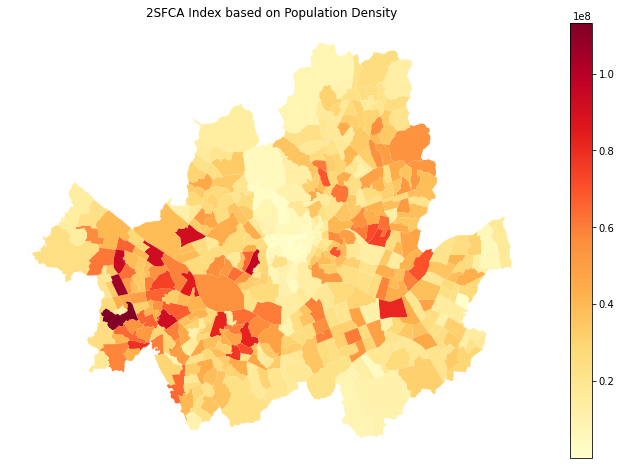

In [135]:
# Choropleth Map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pop_sfca.plot(column='sfca', cmap='YlOrRd', linewidth=0.8, ax=ax, legend=True)

# Add Legend
ax.set_title('2SFCA Index based on Population Density')
ax.set_axis_off()
plt.show()

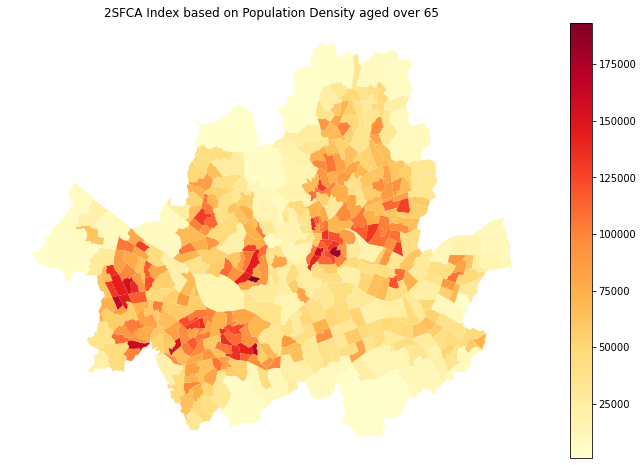

In [136]:
# Choropleth Map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
eld_sfca.plot(column='sfca', cmap='YlOrRd', linewidth=0.8, ax=ax, legend=True)

# Add Legend
ax.set_title('2SFCA Index based on Population Density aged over 65')
ax.set_axis_off()
plt.show()

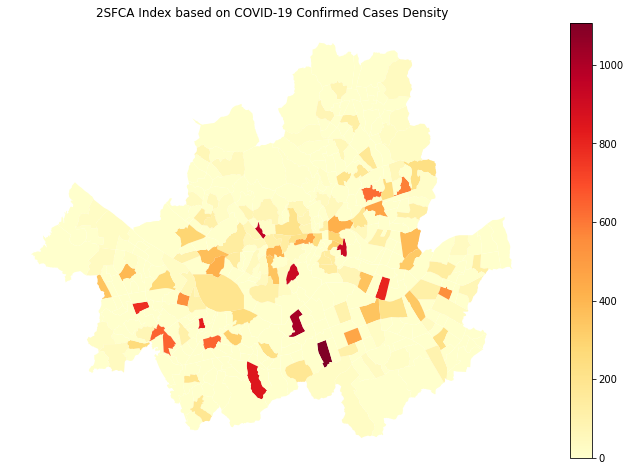

In [137]:
# Choropleth Map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
covid_sfca.plot(column='sfca', cmap='YlOrRd', linewidth=0.8, ax=ax, legend=True)

# Add Legend
ax.set_title('2SFCA Index based on COVID-19 Confirmed Cases Density')
ax.set_axis_off()
plt.show()